<h1><center> Macromolecular Surface concentration </center></h1>

<h4><center> Author: Anisbel León Marcos${^1}$ </center></h4>
<h6><center> ${^1}$Institute for Tropospheric Research (TROPOS)
 ${^1}$leon@tropos.de  
</center></h6>

<br/>

### Models :

#### - Finite-Volume sea-ice ocean model  <a href="https://fesom.de/models/fesom20/">(FESOM2) </a>
> ##### Unstructured mesh, potimized for the Arctic

#### - Regulated Ecosystem Model  <a href="https://ui.adsabs.harvard.edu/abs/2018PrOce.168...65S/abstract">(FESOM-REcoM2) </a>
> ##### Include two phytoplankton classes and coupled with FESOM2


### Equations: 
> #### Adapted from <a href="https://doi.org/10.5194/gmd-16-4883-2023">(Gürses et al. 2023) </a>

<br/>

##### Import packges

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy as cart
import math
import matplotlib as mpl
import codecs
import seaborn as sns
import os,glob,sys
import matplotlib.ticker as ticker
from sklearn.metrics import mean_squared_error
from statannotations.Annotator import Annotator 
from sklearn.neighbors import KNeighborsRegressor
from fpdf import FPDF


#path_ocean = f"/Users/leon/Desktop/Burrows_param/DATA_BGC_model/fesom-recon_BGC/regular_grid_interp/"
path_omf = '/home/manuel/Downloads/Observ_sites_maps/Burows_param/'

## Variables for calculating macromolecules

In [2]:
try:
    os.mkdir('plots')
except OSError:
    pass

try:
    os.mkdir('plots/Sfc_conc_plots')
except OSError:
    pass

plot_dir = './plots/'

In [ ]:
#C_ice_msk = read_files_data(path_ocean + "mask_a_ice*")['VAR']

#C_pcho = read_files_data(path_ocean+'PCHO_var*')['PCHO']
#C_dcaa = read_files_data(path_ocean+'DAA_var*')['DAA']
#C_lip = read_files_data(path_ocean + "Lipids_var*")['LIPIDS']
#C_conc_tot = C_pcho+C_lip+C_dcaa
# doc_exc = read_files_data(path_ocean + "DOC_exc*")['DOC_exc']


In [3]:
def read_files_data(path_dir):
    data = xr.open_mfdataset(path_dir,
                             concat_dim='time', 
                             combine='nested')
    return data


C_omf = read_files_data(path_omf + "fesom_recon_oceanfilms_omf_*")
C_omf_pol = C_omf['OMF_POL']
C_omf_pro = C_omf['OMF_PRO']
C_omf_lip = C_omf['OMF_LIP']
C_omf_tot = C_omf_pol + C_omf_pro + C_omf_lip



In [ ]:
def get_var_reg(v,cond):
    if len(cond) <= 1:
        v = v.where((cond[0][0]>cond[0][1]) &
                    (cond[0][0]<cond[0][2])
                    ,drop=True)
    elif len(cond) > 1:
        v = v.where(((cond[0][0]>cond[0][1]) & 
                 (cond[0][0]<cond[0][2]) &
                 (cond[1][0]>cond[1][1]) & 
                 (cond[1][0]<cond[1][2]))
                 ,drop=True) 
    return v

def find_region(variable,cond,months,na,yr_cond,seasonality=False):
    v_mo_var = []
    v_std_var = []    
        
    for v in variable:
        v = get_var_reg(v,cond)
        v = v.where((v.time.dt.year>yr_cond[0])&
                        (v.time.dt.year<yr_coAnd[1]),drop=True)
        

        # monthly multiannual mean
        for m in months:
            da_t = v.where(v.time.dt.month == m,drop=True)
            da_t['time'] = da_t['time'].dt.year    
            
            da_m_std  = da_t.std(dim = ('lat', 'lon', 'time'), 
                                                skipna=True).values
            da_mean_yrs = da_t.mean(dim=('time','lat', 'lon'),
                                                   skipna=True).values

            v_mo_var.append(float(da_mean_yrs))
            v_std_var.append(float(da_m_std))
        print('mean value', da_mean_yrs, '+-', da_m_std)

    return v_mo_var, v_std_var


def var_alloc_val(data, mo_yr_id, var_type,v_id, var_mo_season):
    for v, va in enumerate(data[mo_yr_id][var_type].keys()):
        data[mo_yr_id][var_type][va][v_id] = var_mo_season[v]

In [ ]:

months = [np.range(0,12)]
lat = C_omf.lat
lon = C_omf.lon
conditions = [[[lat, 60, 90]],
              [[lat, -90, -60]],
              [[lat,23,60]],
              [[lat,-60,-23]],
              [[lat,-23,23]],]

reg_data_globe = {'Arctic':[],
           'Antarctica':[],
           'N. Subtropics':[],
           'S. Subtropics':[],
           'Equator':[],}

for na in reg_data_globe.keys():
    reg_data_globe[na]={              
                        'months_30_yr':[]}
    for i,mo in enumerate(reg_data_globe[na].keys()):
        reg_data_globe[na][mo]= {
                              'var_seasonality':{'Biom':[], 'OMF':[]},
                              'var_season_std':{'Biom':[], 'OMF':[]},
                              }
        for v,va in enumerate(reg_data_globe[na][mo].keys()):
           # reg_data_globe[na][mo][va]['Biom']= {'Total concentration':[],
            #                               'PL':[],
             #                              'PCHO':[],
              #                             'DCAA':[],
               #                            } 
            reg_data_globe[na][mo][va]['OMF']= {
                                           'Total OMF':[],
                                           'OMF_LIP':[],
                                           'OMF_POL':[],
                                           'OMF_PRO':[],} 

#var_ocean = [C_conc_tot*C_ice_msk, 
 #            C_lip*C_ice_msk, 
  #           C_pcho*C_ice_msk, 
   #          C_dcaa*C_ice_msk]

var_omf = [C_omf_tot,
             C_omf['OMF_LIP'],
             C_omf['OMF_POL'],
             C_omf['OMF_PRO'],]


years_set = [[1989,2020]]*len(months)

data = []
for i_id, var in enumerate([var_omf]): # var_ocean, 
#    if i_id == 0:
 #       v_id = 'Biom'
  #  elif i_id == 1:
   #     v_id = 'OMF'
    
    v_id = 'OMF'
    
    print(i_id,v_id)
    region = []
    season = []
    var_value = []
    var_std = []
    var_na = []


    for i,na in enumerate(reg_data_globe.keys()):   
        print(na)
        for y,yr in enumerate(list(reg_data_globe[na].keys())):
            mon = months[y]

            print(yr, mon)
            var_mo_season, var_season_std = find_region(var, 
                                                         conditions[i], 
                                                         mon,
                                                         na,
                                                         years_set[y],
                                                         seasonality=True)  
            var_alloc_val(reg_data_globe[na], yr, 'var_seasonality',v_id, var_mo_season)
            var_alloc_val(reg_data_globe[na], yr, 'var_season_std',v_id, var_season_std)

            for vv in range(len(var_season_std)):
                region.append(na)
                season.append(yr[:3])
                var_value.append(f"{var_mo_season[vv]:.3f}" + f" ({var_season_std[vv]:.3f})")# "\xB1"

#                 var_std.append(var_season_std[vv])
                var_na.append(list(reg_data_globe[na][yr]['var_seasonality'][v_id].keys())[vv])

    data.append({'Region': region,
                    '': var_na,
                   'Season': season,
                   'Average': var_value})


In [ ]:
exit()

In [ ]:
def plot_monthly_series_pannel(axes,C_conc,C_omf,title,limits,pos,left_axis=False):

    t_ax = C_omf[0].time

    #ax = axes[0]
    ax2 = axes #axes[1]
    
    p2, = ax2.plot(t_ax, C_omf[0],'--',label = 'OMF PCHO',linewidth = 2)
#     ax2.fill_between(t_ax, C_omf['OMF_POL']-std_omf[0],C_omf['OMF_POL']+std_omf[0], alpha=0.2)
   # p3, = ax.plot(t_ax, C_conc[0],label= 'ocean PCHO',linewidth = 2)
#     ax.fill_between(t_ax, C_conc[0]-std_conc[0],C_conc[0]+std_conc[0], alpha=0.2)

    p21, = ax2.plot(t_ax, C_omf[1],'--',label = 'OMF DCAA',linewidth = 2)
#     ax2.fill_between(t_ax, C_omf['OMF_PRO']-std_omf[1],C_omf['OMF_PRO']+std_omf[1], alpha=0.2)
   # p31, = ax.plot(t_ax,C_conc[1],label= 'ocean DCAA',linewidth = 2)
#     ax.fill_between(t_ax, C_conc[1]-std_conc[1],C_conc[1]+std_conc[1], alpha=0.2)

    p22, = ax2.plot(t_ax, C_omf[2],'--',label = 'OMF PL',linewidth = 2)
    # excluding negative values that mess up with log scale
#     std_omf_min = [m if m>0 else 1e-9 for m in (C_omf['OMF_LIP'].values-std_omf[2])]
#     ax2.fill_between(t_ax,std_omf_min ,C_omf['OMF_LIP'].values+std_omf[2], alpha=0.2)
  #  p32, = ax.plot(t_ax,C_conc[2],label= 'ocean PL',linewidth = 2)
#     ax.fill_between(t_ax, C_conc[2]-std_conc[2],C_conc[2]+std_conc[2], alpha=0.2)

    
    ax2.set_yscale('log')

    if left_axis:
        ax.set_ylabel("Concentration $(mmolC m^{-3})$", fontsize = 16)
        ax.set_ylim(limits[0])
        ax.yaxis.set_tick_params(labelsize=16)

        ax2.set_ylabel("OMF",fontsize = 16)
        ax2.set_ylim(limits[1])
        ax.set_ylim(limits[0])
        ax2.yaxis.set_tick_params(labelsize=16)
        ax2.yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))   



    elif left_axis==False:
        ax.set_ylim(limits[0])
        ax2.set_ylim(limits[1])
        ax2.yaxis.set_major_locator(mticker.LogLocator(numticks=999))
        ax2.yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))   
        ax2.tick_params(labelleft=False)    
        ax.tick_params(labelleft=False) 



    fig.legend(handles=[p2,p3,p21, p31,p22,p32],ncol = len(ax.lines), 
               bbox_to_anchor=(pos, 1),loc='lower left',fontsize = 16)


In [4]:
def get_month(da,m):
    da_yr = da
    da_t = da_yr.where(da_yr.time.dt.month == m,drop=True)

    da_t_lalo = da_t        
    return da_t_lalo


def percent_trend(da_yr):
    perc_trend=[]
    for y,year in enumerate(da_yr.time.values[:-1]):
        
        perc_trend.append(((da_yr.isel(time = y+1)-da_yr.isel(time = y))))
    return xr.concat(perc_trend,dim = 'time')

def rename_time(C):
    C_mean = C['time'].dt.year    
    return C_mean



def get_monthly_mean(variable,months,yr_cond):
    v_tri_mo_var = []
    v_tri_std_var = []    
    for v in variable:

        v_month = []   
        std_month = []
        for m in months:
            v_ti = get_month(v,m)
            v_ti = v_ti.where((v_ti.time.dt.year>yr_cond[0])&
                            (v_ti.time.dt.year<yr_cond[1]),drop=True)

            v_ti = v_ti.mean(dim='time',skipna=True)

            v_month.append(v_ti)

        v_tri_mo_var.append(xr.concat(v_month,dim = 'time'))
        

    return v_tri_mo_var

months = np.arange(1,13)
var = [C_conc_tot, C_pcho, C_dcaa, C_lip]
years_set = [1989,2020]

variable = get_monthly_mean(var, months, years_set)  
C_conc_tot_mo = variable[0]
C_pcho_mo = variable[1]
C_dcaa_mo = variable[2]
C_lip_mo = variable[3]


In [5]:
C_conc_tot_mo

<xarray.DataArray (time: 12, lat: 721, lon: 1441)>
dask.array<concatenate, shape=(12, 721, 1441), dtype=float64, chunksize=(1, 721, 1441), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -180.0 -179.8 -179.5 -179.2 ... 179.5 179.8 180.0
  * lat      (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
Dimensions without coordinates: time

In [6]:
var_omf = [C_omf_pol, C_omf_pro, C_omf_lip]
variable = get_monthly_mean(var_omf, months, years_set)  
C_omf_pol_mo = variable[0]
C_omf_pro_mo = variable[1]
C_omf_lip_mo = variable[2]


In [7]:
def plot_map(C,name,vm):
    fig, axes = plt.subplots(4, 1,                         # define figure with cartopy
          subplot_kw={'projection': ccrs.Robinson()}, figsize=(5,12))
    axflat = axes.flatten()
        
    plt.subplots_adjust(left = 0, right = 1, top = 0.9, bottom = 0)
    
    fig.suptitle(name,fontsize = 20)
    months = [1,4,6,10]
    titles = ['February', 'May', 'July', 'November']
    cmap = plt.get_cmap('viridis', 11)    # 11 discrete colors

    for idx, var in enumerate(months):
        print(idx, var)
        im = axflat[idx].pcolormesh(C.lon, C.lat, C.isel(time = months[idx]),
                                    cmap=cmap, transform=ccrs.PlateCarree(),vmax = vm )
#                                     norm=mpl.colors.LogNorm(vmin = 1e0, vmax = vm))   #, levels=np.arange(-10,10.1, 0.1))
        axflat[idx].set_title(titles[idx],fontsize = '14')
        axflat[idx].coastlines()
#         function_plot(location,names,axflat[idx],fig)
        
    cbar_ax = fig.add_axes([0.1, -0.05, 0.8, 0.03])
    cbar = fig.colorbar(im,cax = cbar_ax, orientation="horizontal",extend = 'max')
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label(label="$mmol C m^{-3}$", size='large', weight='bold')
    

    
#     plt.savefig(plot_dir + 'Sfc_conc_plots/' + name + '_sfc_conc.png',dpi = 300,bbox_inches="tight")
    plt.show()


    
# funtion to add the boxes with the stations names to the map
def function_plot(location,names,ax,fig):

    ind = 0
    for loc,n in zip(location,names):
        if len(loc) == 2:
            ax.scatter(x = loc[1], y = loc[0],
                 color='m',marker = 'X',
                 transform=ccrs.PlateCarree())
            ax.text(loc[1] + 6, loc[0] - 3, n ,
                 horizontalalignment='right',
                 transform=ccrs.Geodetic(),
                 bbox={'facecolor': 'lightgray', 'boxstyle':'round', 'pad':0.2})
        else:
            ind = 1
            for l in loc:
                ax.scatter(x = l[1], y = l[0],
                     color='m',marker = 'X',
                     transform=ccrs.PlateCarree())

            ax.text(l[1] + 6, l[0] - 3, n ,
                 horizontalalignment='left',
                 transform=ccrs.Geodetic(),
                 bbox={'facecolor': 'lightgray','boxstyle':'round', 'pad':0.2})
            
# plot_map(C_dcaa_mo, 'DAA',2.5)
# plot_map(C_pcho_mo, 'PCHO', 6)
# plot_map(C_lip_mo, 'PL',0.6)

### Plotting maps

### Multipannel plot with all groups for May and November

### 3 pannel plot sfc ocean concent for May

In [8]:
def plot_help(subfig,C,titles,vm, units, colorbar):
    months = 4
    axes = subfig.subplots(nrows=1, ncols=1, sharex=True,
                         subplot_kw={'projection': ccrs.Robinson()})
#     for i,ax in enumerate(axes):
    cmap = plt.get_cmap(colorbar, 11)    # 11 discrete colors
    im = axes.pcolormesh(C.lon, C.lat, C,#.isel(time = months),
                        cmap=cmap, transform=ccrs.PlateCarree(),
                       vmin = 0,vmax = vm)
    axes.set_title(titles[0],loc='right', fontsize = 12)
    axes.set_title(titles[1], loc='left', fontsize = 12)
    axes.coastlines()


    cbar = subfig.colorbar(im, orientation="horizontal", extend = 'max')#,cax = cbar_ax
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label(label=units, size='large', weight='bold')

#     ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
#                   linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

In [9]:

    
def plot_3_pannel(C,names,vm):
    fig = plt.figure(constrained_layout=True,figsize = (10,7))

    (subfig1,subfig2,subfig3) = fig.subfigures(nrows = 1, ncols = 3)
    subfigs = [subfig1,subfig2,subfig3]
    
    for idx,subf in enumerate(subfigs):
        plot_help(subf,C[idx],names[idx],vm[idx],"$mmol\ C$ $m^{-3}$", 'viridis')

    plt.savefig(plot_dir + 'Sfc_conc_plots/3_pannel_sfc_conc_MAY.png',dpi = 300,bbox_inches="tight")
#     fig.tight_layout()

    plt.show()

    
# plot_3_pannel([C_pcho_mo.mean(dim='time'),C_dcaa_mo.mean(dim='time'),C_lip_mo.mean(dim='time')],
#              [['PCHO',r'$\bf{(a)}$'],['DCAA',r'$\bf{(b)}$'],['PL', r'$\bf{(c)}$']],[8,2.5,0.4])


In [ ]:
def plot_6_pannel(C,names,vm):
    fig = plt.figure(constrained_layout=True,figsize = (10,7))

    (subfig1,subfig2,subfig3), (subfig4, subfig5, subfig6) = fig.subfigures(nrows = 2, ncols = 3)
    subfigs = [subfig1, subfig2, subfig3, subfig4, subfig5, subfig6]
    
    unit = "$mmol\ C$ $m^{-3}$"
    colorbar = 'viridis'
    for idx,subf in enumerate(subfigs):
        if idx > 2:
            unit = ' '
            colorbar = 'jet'
        
        plot_help(subf,C[idx],names[idx],vm[idx], unit, colorbar)

    plt.savefig(plot_dir + 'Sfc_conc_plots/6_pannel_sfc_conc_OMF_MAY.png',dpi = 300,bbox_inches="tight")
#     fig.tight_layout()

    plt.show()
    
plot_6_pannel([C_pcho_mo.mean(dim='time'),C_dcaa_mo.mean(dim='time'),C_lip_mo.mean(dim='time'),
              C_omf_pol_mo.mean(dim='time'), C_omf_pro_mo.mean(dim='time'), C_omf_lip_mo.mean(dim='time')],
             [['PCHO$_{sw}$', r'$\bf{(a)}$'],['DCAA$_{sw}$', r'$\bf{(b)}$'],['PL$_{sw}$', r'$\bf{(c)}$'],
              ['PCHO$_{aer}$ OMF', r'$\bf{(d)}$'],['DCAA$_{aer}$ OMF', r'$\bf{(e)}$'],['PL$_{aer}$ OMF',r'$\bf{(f)}$']],
              [8,2.5,0.4,0.006, 0.028,0.35])


### Calculating seasonal mean values and std

In [12]:
def get_var_reg(v,cond):
    if len(cond) <= 1:
        v = v.where((cond[0][0]>cond[0][1]) &
                    (cond[0][0]<cond[0][2])
                    ,drop=True)
    elif len(cond) > 1:
        v = v.where(((cond[0][0]>cond[0][1]) & 
                 (cond[0][0]<cond[0][2]) &
                 (cond[1][0]>cond[1][1]) & 
                 (cond[1][0]<cond[1][2]))
                 ,drop=True) 
    return v

def find_region(variable,cond,months,na,yr_cond,seasonality=False):
    v_tri_mo_var = []
    v_tri_std_var = []    
        
    for v in variable:
        v = get_var_reg(v,cond)
        v = v.where((v.time.dt.year>yr_cond[0])&
                        (v.time.dt.year<yr_coAnd[1]),drop=True)
        
        da_time_mean = []
        da_t_reg_m_list = []

        # seasonal multiannual mean
        for m in months:
            da_t = v.where(v.time.dt.month == m,drop=True)
            da_t['time'] = da_t['time'].dt.year    
            da_t_reg_m_list.append(da_t)

            
#         da_tri_mean = []
#         for yr in range(len(da_t['time'])):
#             da_t_reg_m_list_yr = xr.concat([da_t_reg_m_list[0].isel(time=yr),
#                                             da_t_reg_m_list[1].isel(time=yr),
#                                             da_t_reg_m_list[2].isel(time=yr)], dim='t')
#             da_tri_mean.append(da_t_reg_m_list_yr.mean( dim='t', skipna=True))

#         da_tri_mean_yrs = xr.concat(da_tri_mean, dim='time')
        da_tri_mean_yrs = xr.concat(da_t_reg_m_list, dim='time')



        da_tri_m_std  = da_tri_mean_yrs.std(dim = ('lat', 'lon', 'time'), skipna=True).values
        da_tri_mean_yrs = da_tri_mean_yrs.mean(dim=('time','lat', 'lon'),skipna=True).values

#         da_tri_mean_yrs = xr.concat(da_t_reg_m_list, dim='time')

#         da_tri_m_std  = da_tri_mean_yrs.std(dim = ('lat', 'lon', 'time'), skipna=True).values
#         da_tri_mean_yrs = da_tri_mean_yrs.mean(skipna=True).values  

        v_tri_mo_var.append(float(da_tri_mean_yrs))
        v_tri_std_var.append(float(da_tri_m_std))
        print('mean value', da_tri_mean_yrs, '+-', da_tri_m_std)

    return v_tri_mo_var, v_tri_std_var


def var_alloc_val(data, mo_yr_id, var_type,v_id, var_mo_season):
    for v, va in enumerate(data[mo_yr_id][var_type].keys()):
        data[mo_yr_id][var_type][va][v_id] = var_mo_season[v]

In [13]:
[[1989,2020]]*4

[[1989, 2020], [1989, 2020], [1989, 2020], [1989, 2020]]

In [14]:
months = [[6, 7, 8],[1,2,12],[4,5,6], [10,11,12]]
lat = C_pcho.lat
lon = C_pcho.lon
conditions = [[[lat, 60, 90]],
              [[lat, -90, -60]],
              [[lat,23,60]],
              [[lat,-60,-23]],
              [[lat,-23,23]],]

reg_data_globe = {'Arctic':[],
           'Antarctica':[],
           'N. Subtropics':[],
           'S. Subtropics':[],
           'Equator':[],}

for na in reg_data_globe.keys():
    reg_data_globe[na]={              
                        'JJA_months_30_yr':[],
                        'DJF_months_30_yr':[],             
                        'AMJ_months_30_yr':[],
                        'OND_months_30_yr':[],}
    for i,mo in enumerate(reg_data_globe[na].keys()):
        reg_data_globe[na][mo]= {
                              'var_seasonality':{'Biom':[], 'OMF':[]},
                              'var_season_std':{'Biom':[], 'OMF':[]},
                              }
        for v,va in enumerate(reg_data_globe[na][mo].keys()):
            reg_data_globe[na][mo][va]['Biom']= {'Total concentration':[],
                                           'PL':[],
                                           'PCHO':[],
                                           'DCAA':[],
                                           } 
            reg_data_globe[na][mo][va]['OMF']= {
                                           'Total OMF':[],
                                           'OMF_LIP':[],
                                           'OMF_POL':[],
                                           'OMF_PRO':[],} 

var_ocean = [C_conc_tot*C_ice_msk, 
             C_lip*C_ice_msk, 
             C_pcho*C_ice_msk, 
             C_dcaa*C_ice_msk]

var_omf = [C_omf_tot,
             C_omf['OMF_LIP'],
             C_omf['OMF_POL'],
             C_omf['OMF_PRO'],]


years_set = [[1989,2020]]*len(months)

data = []
for i_id, var in enumerate([var_ocean, var_omf]):
    if i_id == 0:
        v_id = 'Biom'
    elif i_id == 1:
        v_id = 'OMF'
    print(i_id,v_id)
    region = []
    season = []
    var_value = []
    var_std = []
    var_na = []


    for i,na in enumerate(reg_data_globe.keys()):   
        print(na)
        for y,yr in enumerate(list(reg_data_globe[na].keys())):
            mon = months[y]

            print(yr, mon)
            var_mo_season, var_season_std = find_region(var, 
                                                         conditions[i], 
                                                         mon,
                                                         na,
                                                         years_set[y],
                                                         seasonality=True)  
            var_alloc_val(reg_data_globe[na], yr, 'var_seasonality',v_id, var_mo_season)
            var_alloc_val(reg_data_globe[na], yr, 'var_season_std',v_id, var_season_std)

            for vv in range(len(var_season_std)):
                region.append(na)
                season.append(yr[:3])
                var_value.append(f"{var_mo_season[vv]:.3f}" + f" ({var_season_std[vv]:.3f})")# "\xB1"

#                 var_std.append(var_season_std[vv])
                var_na.append(list(reg_data_globe[na][yr]['var_seasonality'][v_id].keys())[vv])

    data.append({'Region': region,
                    '': var_na,
                   'Season': season,
                   'Average': var_value})


0 Biom
Arctic
JJA_months_30_yr [6, 7, 8]
mean value 3.7902883818076445 +- 1.769213291442489
mean value 0.584872666057297 +- 0.3567636533795416
mean value 2.4682843564884527 +- 1.2261237537819316
mean value 0.7371313592618942 +- 0.36617104786678556
DJF_months_30_yr [1, 2, 12]
mean value 0.6654799516187253 +- 0.28592877610750783
mean value 2.365718106904701e-06 +- 0.00013653719028014732
mean value 0.5124414617427205 +- 0.2201735380699805
mean value 0.1530361241578977 +- 0.06575288579064671
AMJ_months_30_yr [4, 5, 6]
mean value 4.86875775339956 +- 3.4454117992593583
mean value 0.5942497103450811 +- 0.4916827439255704
mean value 3.2915235557474807 +- 2.3718610215767573
mean value 0.9829844873069974 +- 0.7083353804917898
OND_months_30_yr [10, 11, 12]
mean value 0.9078825993289235 +- 0.7398905681229889
mean value 0.025326954294149124 +- 0.05043038082009302
mean value 0.6795993049094955 +- 0.5510572897476554
mean value 0.20295634012527866 +- 0.1645684007011066
Antarctica
JJA_months_30_yr [6, 

mean value 0.13448050374868942 +- 0.04669683585907491
mean value 0.0025310064471450403 +- 0.0008121062781044357
mean value 0.011924873352753872 +- 0.003797978020283954
AMJ_months_30_yr [4, 5, 6]
mean value 0.06857737361702933 +- 0.05675975174985024
mean value 0.05727038432940613 +- 0.051306785300333335
mean value 0.001978098127895566 +- 0.00104703045488314
mean value 0.009328891159727643 +- 0.004907684001851086
OND_months_30_yr [10, 11, 12]
mean value 0.15206509963221318 +- 0.0612413439660939
mean value 0.13828743146125072 +- 0.057616703368478524
mean value 0.0024121117591539534 +- 0.0009310768371212582
mean value 0.011365556411808524 +- 0.004361315019295133
Equator
JJA_months_30_yr [6, 7, 8]
mean value 0.146551377655563 +- 0.026962920926637202
mean value 0.12363669503754708 +- 0.02592335473434328
mean value 0.004027840370426788 +- 0.0004406751768299161
mean value 0.018886842247589138 +- 0.002040998853121263
DJF_months_30_yr [1, 2, 12]
mean value 0.14861148879279387 +- 0.02557190239050

In [10]:
    
df_ocean = pd.DataFrame(data[0])
df_omf = pd.DataFrame(data[1])

import pickle 
with open('Global_regions.pkl', 'wb') as f:
    pickle.dump(reg_data_globe, f)
df_ocean

,Region,,Season,Average
0,Arctic,Total concentration,JJA,3.790 (1.769)
1,Arctic,PL,JJA,0.585 (0.357)
2,Arctic,PCHO,JJA,2.468 (1.226)
3,Arctic,DCAA,JJA,0.737 (0.366)
4,Arctic,Total concentration,DJF,0.665 (0.286)
...,...,...,...,...
75,Equator,DCAA,AMJ,1.814 (0.185)
76,Equator,Total concentration,OND,7.927 (0.862)
77,Equator,PL,OND,0.116 (0.026)
78,Equator,PCHO,OND,6.015 (0.656)


In [11]:
def sel_df_var(df, var_na, early_season=False):
    if early_season:
        s1, s2 = 'AMJ', 'OND'
    else:
        s1, s2 = 'JJA', 'DJF'
        
    df_sell = df[df['']==var_na].drop(columns=[''])
    df_new = pd.DataFrame()
    df_s1 = df_sell[df_sell['Season']==s1]
    df_s2 = df_sell[df_sell['Season']==s2]
    df_new['Regions']  = list(reg_data_globe.keys())
    df_new[s1]  = list(df_s1['Average'] )
    df_new[s2]  = list(df_s2['Average'] )
    
    return df_new

def plot_table_0(vax, var_na, df_new, x1, x2, early_season=False):
    if early_season:
        s1, s2 = 'AMJ', 'OND'
    else:
        s1, s2 = 'JJA', 'DJF'

    header = ax.table(cellText=[['Regions']],loc='bottom',
                         bbox=[0, 0.6, 0.265, 0.3]

                          )
    table = ax.table(cellText=[[var_na]],#, 'PL', 'DCAA', 'Total concentration'
                         loc='bottom',
                         bbox=[x1, 0.75, x2, 0.15]
                        #
                          )
    table = ax.table(cellText=[[s1, s2]],
                         loc='bottom',
                         bbox=[x1, 0.6, x2, 0.15]

                          )

    ax.table(cellText=df_new.values,
                         loc='bottom',
                         bbox=[0, 0, 0.8, 0.6]

                         )
    
def plot_table_1(vax, var_na, df_new, x1, x2, early_season=False):
    
    if early_season:
        s1, s2 = 'AMJ', 'OND'
    else:
        s1, s2 = 'JJA', 'DJF'

    table = ax.table(cellText=[[var_na]],#, 'PL', 'DCAA', 'Total concentration'
                         loc='bottom',
                         bbox=[x1, 0.75, x2, 0.15]
                        #
                          )
    table = ax.table(cellText=[[s1, s2]],
                         loc='bottom',
                         bbox=[x1, 0.6, x2, 0.15]

                          )

    ax.table(cellText=df_new.values,
                         loc='bottom',
                         bbox=[x1, 0, 0.5, 0.6]

                         )

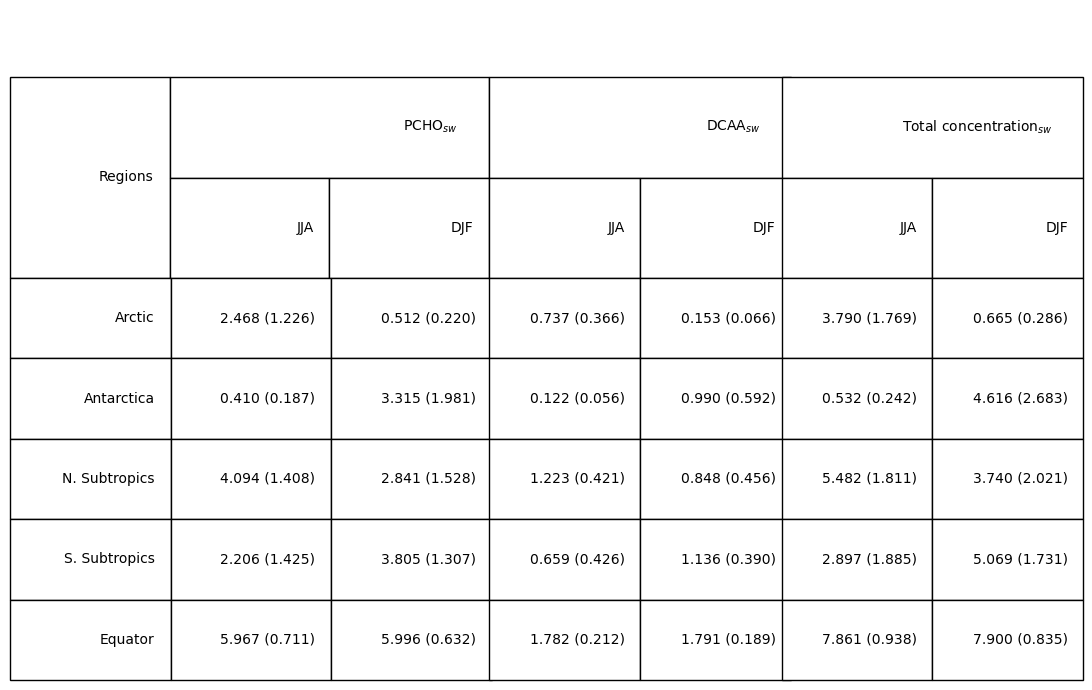

In [50]:
fig, ax = plt.subplots(figsize = (16,7)) 
ax.set_axis_off() 
x1, x2  = 0, 0
idx  = 0.265
x1 = idx

df_new = sel_df_var(df_ocean, 'PCHO')
plot_table_0(ax, 'PCHO$_{sw}$', df_new, idx, x1+idx)

lims = [[0.795, 0.5], [1.28, 0.5]]#, [1.8, 0.5]]
for xl, var_na in enumerate(['DCAA', 'Total concentration']):#,, 'PL'
    df_new = sel_df_var(df_ocean, var_na)
    plot_table_1(ax, var_na+'$_{sw}$', df_new.drop(columns=['Regions']), lims[xl][0], lims[xl][1])
plt.tight_layout() 
plt.savefig('Table_mean_ocean_concentration_region_total.png', dpi = 300)

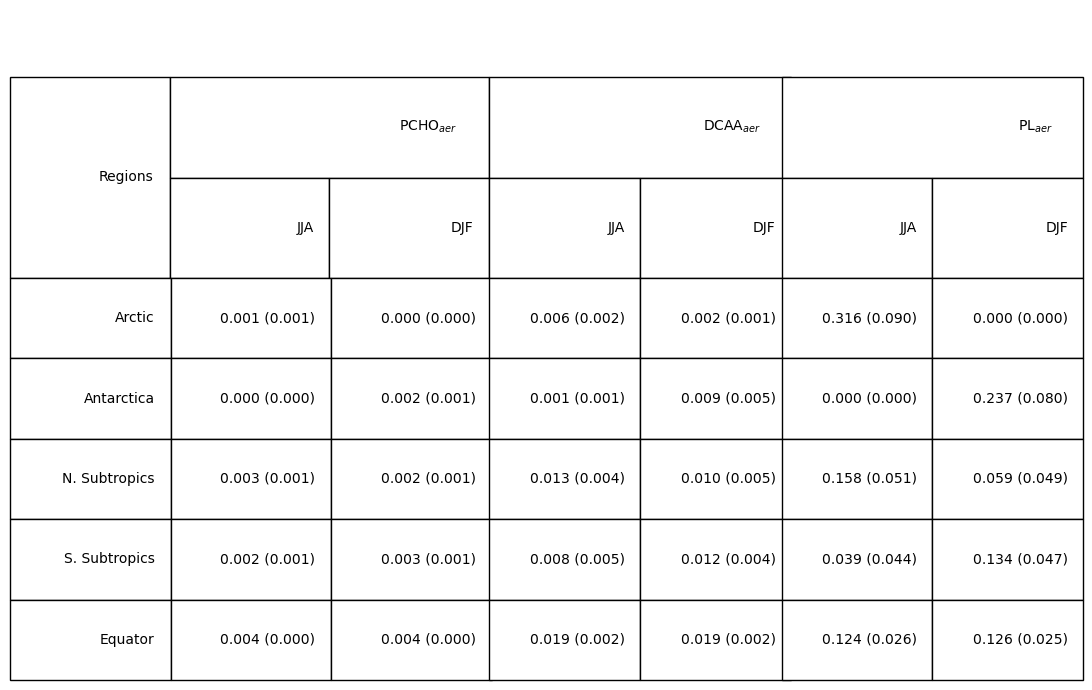

In [51]:
fig, ax = plt.subplots(figsize = (16,7)) 
ax.set_axis_off() 
x1, x2  = 0, 0
idx  = 0.265
x1 = idx

df_new = sel_df_var(df_omf, 'OMF_POL')
plot_table_0(ax, 'PCHO$_{aer}$', df_new, idx, x1+idx)

var_na_new = ['DCAA', "PL"]
lims = [[0.795, 0.5], [1.28, 0.5]]
for xl, var_na in enumerate(['OMF_PRO', 'OMF_LIP']):
    df_new = sel_df_var(df_omf, var_na)
    plot_table_1(ax, var_na_new[xl]+'$_{aer}$', df_new.drop(columns=['Regions']), lims[xl][0], lims[xl][1])
plt.tight_layout() 

plt.savefig('Table_mean_omf_region.png', dpi = 300)

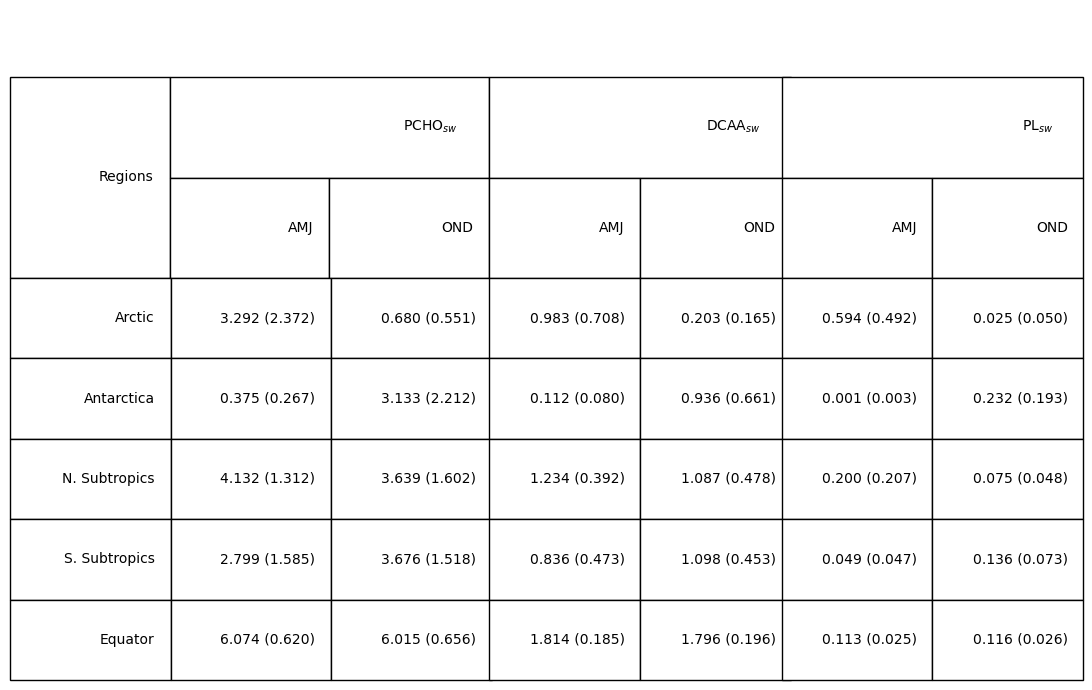

In [52]:
fig, ax = plt.subplots(figsize = (16,7)) 
ax.set_axis_off() 
x1, x2  = 0, 0
idx  = 0.265
x1 = idx

df_new = sel_df_var(df_ocean, 'PCHO', early_season=True)
plot_table_0(ax, 'PCHO$_{sw}$', df_new, idx, x1+idx, early_season=True)

lims = [[0.795, 0.5], [1.28, 0.5]]
for xl, var_na in enumerate(['DCAA', 'PL']):
    df_new = sel_df_var(df_ocean, var_na, early_season=True)
    plot_table_1(ax, var_na+'$_{sw}$', df_new.drop(columns=['Regions']), 
                 lims[xl][0], lims[xl][1], early_season=True)
plt.tight_layout() 
plt.savefig('Table_mean_ocean_concentration_early_season_region.png', dpi = 300)

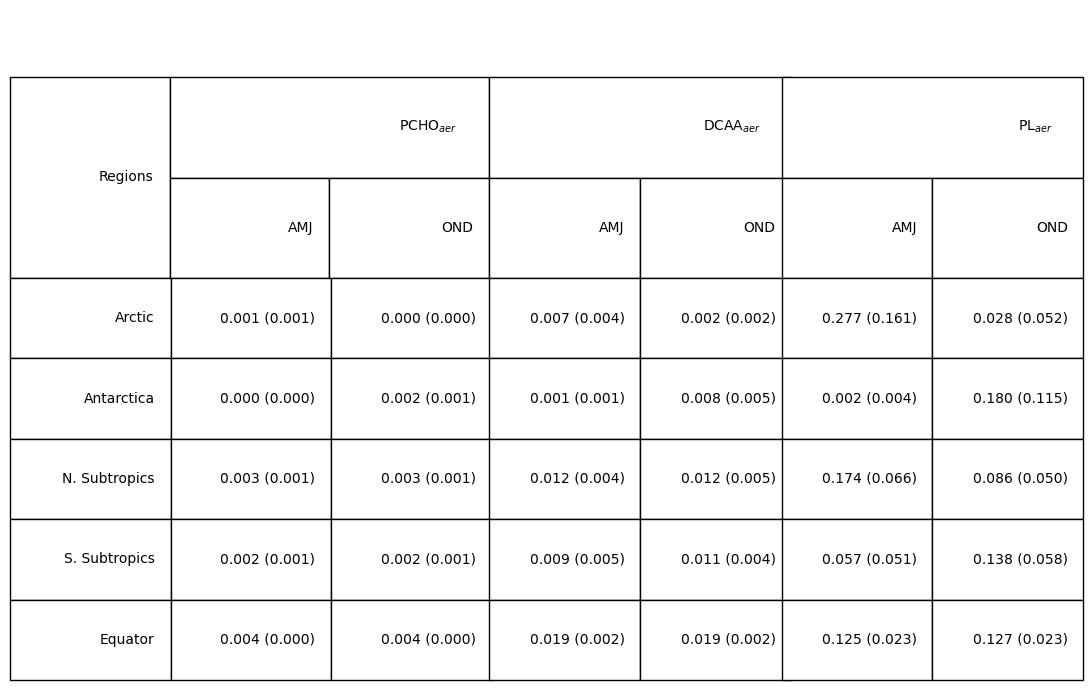

In [53]:
fig, ax = plt.subplots(figsize = (16,7)) 
ax.set_axis_off() 
x1, x2  = 0, 0
idx  = 0.265
x1 = idx

df_new = sel_df_var(df_omf, 'OMF_POL', early_season=True)
plot_table_0(ax, 'PCHO$_{aer}$', df_new, idx, x1+idx, early_season=True)

var_na_new = ['DCAA', "PL"]
lims = [[0.795, 0.5], [1.28, 0.5]]
for xl, var_na in enumerate(['OMF_PRO', 'OMF_LIP']):
    df_new = sel_df_var(df_omf, var_na, early_season=True)
    plot_table_1(ax, var_na_new[xl]+'$_{aer}$', 
                 df_new.drop(columns=['Regions']), lims[xl][0], lims[xl][1], early_season=True)
plt.tight_layout() 

plt.savefig('Table_mean_omf_early_season_region.png', dpi = 300)